In [23]:
import numpy as np 
import pandas as pd

from subprocess import check_output
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from sklearn.model_selection import  train_test_split
import time #helper libraries
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from numpy import newaxis

Using TensorFlow backend.


In [8]:
df = pd.read_csv('prices.csv')
df.head(5)

,date,symbol,open,close,low,high,volume
0,2016-01-05 00:00:00,WLTW,123.430000,125.839996,122.309998,126.250000,2163600.0
1,2016-01-06 00:00:00,WLTW,125.239998,119.980003,119.940002,125.540001,2386400.0
2,2016-01-07 00:00:00,WLTW,116.379997,114.949997,114.930000,119.739998,2489500.0
3,2016-01-08 00:00:00,WLTW,115.480003,116.620003,113.500000,117.440002,2006300.0
4,2016-01-11 00:00:00,WLTW,117.010002,114.970001,114.089996,117.330002,1408600.0


In [18]:
df.dropna(axis=0, inplace=True)
df

,date,symbol,open,close,low,high,volume
0,2016-01-05 00:00:00,WLTW,123.430000,125.839996,122.309998,126.250000,2163600.0
1,2016-01-06 00:00:00,WLTW,125.239998,119.980003,119.940002,125.540001,2386400.0
2,2016-01-07 00:00:00,WLTW,116.379997,114.949997,114.930000,119.739998,2489500.0
3,2016-01-08 00:00:00,WLTW,115.480003,116.620003,113.500000,117.440002,2006300.0
4,2016-01-11 00:00:00,WLTW,117.010002,114.970001,114.089996,117.330002,1408600.0
...,...,...,...,...,...,...,...
591532,2014-12-04,STZ,94.010002,94.180000,93.690002,94.529999,655700.0
591533,2014-12-04,SWK,95.050003,94.839996,94.330002,95.290001,1236500.0
591534,2014-12-04,SWKS,68.000000,69.750000,67.220001,70.139999,6602900.0
591535,2014-12-04,SWN,30.600000,30.590000,30.379999,30.969999,6404600.0


In [21]:
amzn = df[df['symbol']=='AMZN']
amzn_stock_prices = amzn.close.values.astype('float32')
amzn_stock_prices = amzn_stock_prices.reshape(1240, 1)
amzn_stock_prices.shape

(1240, 1)

In [22]:
amzn

,date,symbol,open,close,low,high,volume
284,2010-01-04,AMZN,136.250000,133.899994,133.139999,136.610001,7599900.0
751,2010-01-05,AMZN,133.429993,134.690002,131.809998,135.479996,8851900.0
1219,2010-01-06,AMZN,134.600006,132.250000,131.649994,134.729996,7178800.0
1687,2010-01-07,AMZN,132.009995,130.000000,128.800003,132.320007,11030200.0
2155,2010-01-08,AMZN,130.559998,133.520004,129.029999,133.679993,9830500.0
...,...,...,...,...,...,...,...
589198,2014-11-28,AMZN,336.029999,338.640015,336.029999,341.260010,3051800.0
589688,2014-12-01,AMZN,338.119995,326.000000,325.929993,340.640015,4944900.0
590178,2014-12-02,AMZN,327.500000,326.309998,323.250000,327.929993,2790300.0
590668,2014-12-03,AMZN,325.730011,316.500000,314.359985,326.769989,5681000.0


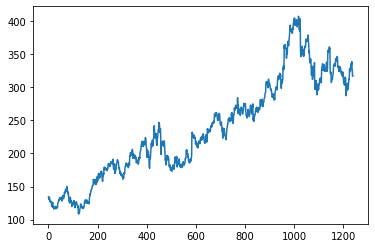

In [24]:
plt.plot(amzn_stock_prices)
plt.show()

scaler = MinMaxScaler(feature_range=(0, 1))
amzn_stock_prices = scaler.fit_transform(amzn_stock_prices)

In [25]:
train_size = int(len(amzn_stock_prices) * 0.80)
test_size = len(amzn_stock_prices) - train_size
train, test = amzn_stock_prices[0:train_size,:], amzn_stock_prices[train_size:len(amzn_stock_prices),:]
print(len(train), len(test))

992 248


In [26]:
# convert an array of values into a dataset matrix
def create(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

In [27]:
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create(train, look_back)
testX, testY = create(test, look_back)

In [28]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [29]:
#Step 2 Build Model
model = Sequential()

model.add(LSTM(
    input_dim=1,
    output_dim=50,
    return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(
    100,
    return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(
    output_dim=1))
model.add(Activation('linear'))

start = time.time()
model.compile(loss='mse', optimizer='rmsprop')
print ('compilation time : ', time.time() - start)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(return_sequences=True, input_shape=(None, 1), units=50)`
  import sys


compilation time :  0.011009931564331055


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=1)`
  app.launch_new_instance()


In [30]:
model.fit(
    trainX,
    trainY,
    batch_size=128,
    nb_epoch=10,
    validation_split=0.05)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 940 samples, validate on 50 samples
Epoch 1/10
940/940 [==============================] - 1s 2ms/step - loss: 0.1073 - val_loss: 0.4738
Epoch 2/10
940/940 [==============================] - 0s 82us/step - loss: 0.0633 - val_loss: 0.3221
Epoch 3/10
940/940 [==============================] - 0s 74us/step - loss: 0.0334 - val_loss: 0.1985
Epoch 4/10
940/940 [==============================] - 0s 78us/step - loss: 0.0190 - val_loss: 0.1270
Epoch 5/10
940/940 [==============================] - 0s 76us/step - loss: 0.0155 - val_loss: 0.0929
Epoch 6/10
940/940 [==============================] - 0s 66us/step - loss: 0.0134 - val_loss: 0.0803
Epoch 7/10
940/940 [==============================] - 0s 66us/step - loss: 0.0115 - val_loss: 0.0593
Epoch 8/10
940/940 [==============================] - 0s 69us/step - loss: 0.0090 - val_loss: 0.0453
Epoch 9/10
940/940 [==============================] - 0s 66us/step - loss: 0.0067 - val_loss: 0.0174
Epoch 10/10
940/940 [==========================

[[0.8323213]]
[[1.981662]]
[[4.545953]]
[[9.33472]]
[[13.180516]]
[[ 357.008 ]
 [ 700.0172]
 [1465.3042]
 [2894.4639]
 [4042.2034]]


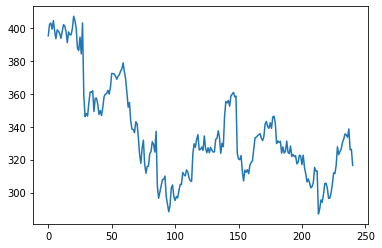

In [31]:
def plot_results_multiple(predicted_data, true_data,length):
    plt.plot(scaler.inverse_transform(true_data.reshape(-1, 1))[length:])
    plt.plot(scaler.inverse_transform(np.array(predicted_data).reshape(-1, 1))[length:])
    plt.show()
    
#predict lenght consecutive values from a real one
def predict_sequences_multiple(model, firstValue,length):
    prediction_seqs = []
    curr_frame = firstValue
    
    for i in range(length): 
        predicted = []        
        
        print(model.predict(curr_frame[newaxis,:,:]))
        predicted.append(model.predict(curr_frame[newaxis,:,:])[0,0])
        
        curr_frame = curr_frame[0:]
        curr_frame = np.insert(curr_frame[0:], i+1, predicted[-1], axis=0)
        
        prediction_seqs.append(predicted[-1])
        
    return prediction_seqs

predict_length=5
predictions = predict_sequences_multiple(model, testX[0], predict_length)
print(scaler.inverse_transform(np.array(predictions).reshape(-1, 1)))
plot_results_multiple(predictions, testY, predict_length)